In [1]:
import fix_sys_path
from plasma_classes import *
from plasma_utils import *
from matplotlib import pyplot as plt
from matplotlib import animation
from tqdm import tqdm

In [2]:
L = 1e-2
N_x = 1000
N_p = 10000
h = L/N_x
tau = 5e-13

In [3]:
n0 = 1e17
n1 = n0*N_x*0.8/(N_p)
q = 1.60217e-19
m_e = 9.1093837e-31
m_i = 1.672e-27*131
epsilon = 8.85e-12

In [4]:
eV = 11600

In [5]:
E1_factor = 1.60218e-19

In [6]:
E1 = 18.3*E1_factor
alpha = 0.62

In [7]:
T_e = eV*20
T_i = 600
k_b = 1.38e-23
v_t_e = math.sqrt(3*k_b*T_e/m_e)
vmin_e = -3*v_t_e
vmax_e = 3*v_t_e
v_t_i = math.sqrt(3*k_b*T_i/m_i)
vmin_i = -3*v_t_i
vmax_i = 3*v_t_i

In [8]:
left_wall = Wall(0, L/10, 0, h, "left")
right_wall = Wall(9*L/10, L, 0, h, "right")

In [9]:
walls = (left_wall, right_wall)

In [10]:
r_d = math.sqrt(epsilon * k_b * T_e / (q * q * n0));

In [11]:
r_d

0.00010506222052218572

In [12]:
h

1e-05

In [13]:
tau_courant = 0.25*h/v_t_e
tau_courant

7.699106788509382e-13

In [14]:
tau_plasma = 1/(math.sqrt(n0*q*q/(m_e*epsilon))/(2*np.pi))
tau_plasma

3.5211733480548816e-10

In [15]:
tau

5e-13

In [16]:
ions = Particles(N_p, n1, q, m_i)
electrons = Particles(N_p, n1, -q, m_e)
nodes = Nodes(N_x)

In [17]:
set_homogeneous(electrons, left_wall.right*h, right_wall.left*h)

In [18]:
set_homogeneous(ions, left_wall.right*h, right_wall.left*h)

In [19]:
A_e = (electrons.q*(tau**2))/(electrons.m*h)
A_i = (ions.q*(tau**2))/(ions.m*h)

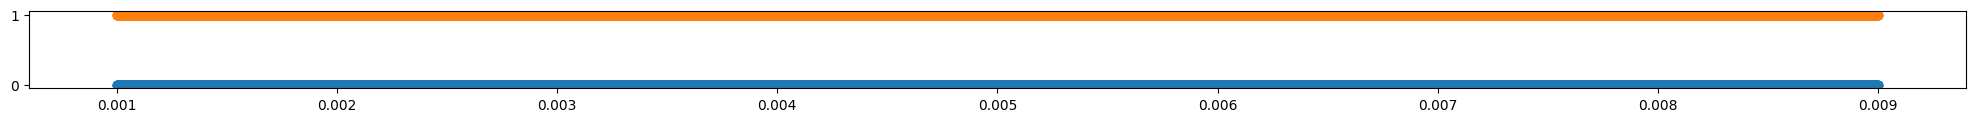

In [20]:
fig, ax = plt.subplots(1, 1)
ax.scatter(electrons.x, np.zeros(electrons.x.shape))
ax.scatter(ions.x, np.ones(ions.x.shape))
fig.set_size_inches((25, 1))


In [21]:
e_integral = get_integral(Maxwell(T_e, k_b, m_e), vmin_e, vmax_e, 100000)
i_integral = get_integral(Maxwell(T_i, k_b, m_i), vmin_i, vmax_i, 100000)

In [22]:
see_integral = get_integral(Maxwell(1*eV, k_b, m_e), vmin_e, vmax_e, 100000)

In [23]:
set_distr(electrons, e_integral, h, tau)
set_distr(ions, i_integral, h, tau)

Particles are already denormalized
Particles are already denormalized


In [24]:
electrons.normalise(h, tau)
ions.normalise(h, tau)

Particles are already normalised
Particles are already normalised


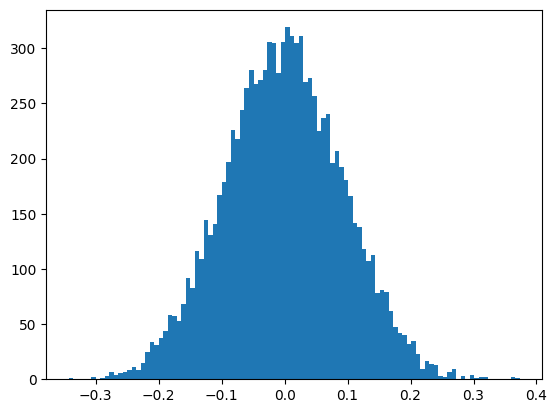

In [25]:
plt.hist(electrons.v, bins = 100)
%matplotlib inline

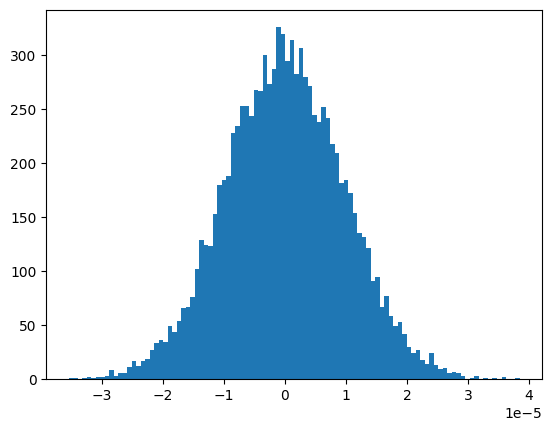

In [26]:
plt.hist(ions.v, bins = 100)
%matplotlib inline

In [27]:
get_rho(nodes, electrons)
get_rho(nodes, ions)

In [28]:
constant_conc = nodes.conc_e[int(N_x/2)].copy()*2

In [29]:
calc_fields(nodes, h, epsilon, walls=walls)

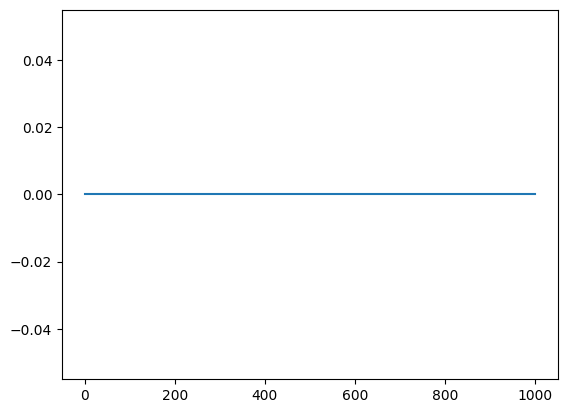

In [30]:
plt.plot(nodes.phi)

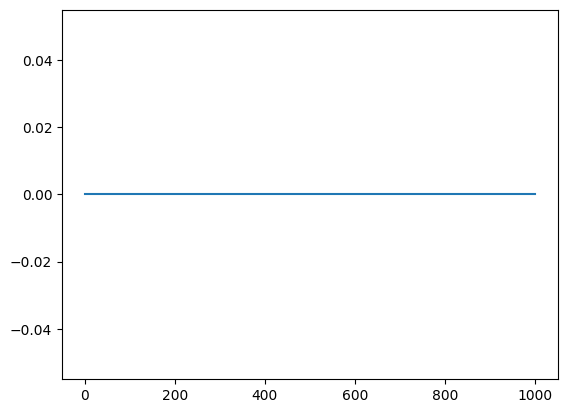

In [31]:
plt.plot(nodes.E)

In [32]:
accel(electrons, nodes, A_e, zerostep=True)
accel(ions, nodes, A_i, zerostep=True)

In [33]:
electron_distrs = []
ion_distrs = []

In [34]:
phi_over_time = []
E_over_time = []

In [35]:
n = 10000

In [36]:
see_dict = {"E1": E1, "alpha": alpha, "h": h, "tau": tau}

In [37]:
energy_dict = {"electric": [], "kinetic": [], "summ": [], "h": h, "tau": tau, "nodes": nodes, "count": 0}

In [38]:
len(energy_dict["summ"])

0

In [39]:
see_dict = {"E1": E1, "alpha": alpha, "h": h, "tau": tau, "see_integral": see_integral}

In [40]:
maxwellise = True

In [41]:
saving = True

In [42]:
flux = True

In [43]:
n_range = (200, 800)

In [44]:
N = np.sum(range_mask(electrons, n_range))

In [45]:
electrons_over_time = []

In [46]:
every_n_step = 500

In [47]:
conc_history = []

In [48]:
constant_conc

1.996799999999975e+17

In [49]:

file_path = "test1.bin"

In [50]:
# if os.path.isfile(file_path):
#     os.remove(file_path)

In [51]:
every_n_save = 100

In [52]:
import cProfile

In [53]:
constant_n = 0
for particles in (electrons, ions):
    mask = range_mask(particles, (500, 550))
    slc = particles[mask]
    constant_n += slc.n_macro

In [54]:
constant_n

1250

In [55]:
# electrons = particles_lst[0].deepcopy()
# ions = particles_lst[0].deepcopy()

In [56]:
for t in tqdm(range(n)):
    try:
        move(electrons, nodes)
        move(ions, nodes)
    except Exception:
        print("number of iteration: ", t)
        break

    nodes.rho *= 0
    nodes.conc_i *= 0
    nodes.conc_e *= 0
    account_walls([electrons, ions], walls, Energy=energy_dict)
    get_rho(nodes, electrons)
    get_rho(nodes, ions)
    calc_fields(nodes, h, epsilon, walls=walls)
    accel(electrons, nodes, A_e)
    accel(ions, nodes, A_i)
    
    if t % every_n_save == 0 and saving == True:
        save_system_state(t, nodes, (electrons, ions), walls, file_path)
        
    if maxwellise and t % every_n_step == 0:
        set_distr(electrons, e_integral, h, tau, n_range)

    if flux and t % every_n_step == 0 and t != 0:
        pump_particles((electrons, ions), constant_n, n_range, windows=12)

  6%|▌         | 566/10000 [00:01<00:24, 379.98it/s]

FLUX!!! 11
FLUX!!! 12
FLUX!!! 9
FLUX!!! 1
FLUX!!! 4


 11%|█         | 1079/10000 [00:02<00:22, 391.43it/s]

FLUX!!! 9
FLUX!!! 4


 16%|█▌        | 1558/10000 [00:04<00:22, 374.84it/s]

FLUX!!! 2


 21%|██        | 2070/10000 [00:05<00:20, 379.29it/s]

FLUX!!! 4
FLUX!!! 2
FLUX!!! 3


 25%|██▌       | 2539/10000 [00:06<00:20, 368.07it/s]

FLUX!!! 4
FLUX!!! 2
FLUX!!! 2
FLUX!!! 8


 31%|███       | 3075/10000 [00:08<00:18, 369.31it/s]

FLUX!!! 3
FLUX!!! 3
FLUX!!! 4
FLUX!!! 2


 36%|███▌      | 3578/10000 [00:09<00:16, 379.66it/s]

FLUX!!! 3


 40%|████      | 4046/10000 [00:10<00:15, 376.27it/s]

FLUX!!! 3
FLUX!!! 4


 46%|████▌     | 4551/10000 [00:12<00:14, 376.89it/s]

FLUX!!! 3


 51%|█████     | 5053/10000 [00:13<00:13, 371.24it/s]

FLUX!!! 2


 56%|█████▌    | 5561/10000 [00:14<00:11, 391.33it/s]

FLUX!!! 6
FLUX!!! 8
FLUX!!! 2


 66%|██████▌   | 6561/10000 [00:17<00:08, 394.93it/s]

FLUX!!! 3
FLUX!!! 4


 70%|███████   | 7050/10000 [00:18<00:07, 404.46it/s]

FLUX!!! 1


 76%|███████▌  | 7585/10000 [00:19<00:05, 403.44it/s]

FLUX!!! 4


 86%|████████▌ | 8578/10000 [00:22<00:03, 376.80it/s]

FLUX!!! 2


 95%|█████████▌| 9548/10000 [00:24<00:01, 368.50it/s]

FLUX!!! 1
FLUX!!! 1


100%|██████████| 10000/10000 [00:26<00:00, 382.87it/s]


In [174]:
len(energy_dict["electric"])

785

In [56]:
electrons_over_time = []
ions_over_time = []
e_conc_history = []
i_conc_history = []
phi_center = []
phi_over_time = []
e_over_time = []
for nodes, particles, walls in loop_over_states(file_path):
    electrons_over_time.append(particles[0].n_macro)
    ions_over_time.append(particles[1].n_macro)
    e_conc_history.append(nodes.conc_e.copy())
    i_conc_history.append(nodes.conc_i.copy())
    phi_over_time.append(nodes.phi.copy())
    e_over_time.append(nodes.E.copy())
    phi_center.append(nodes.phi[500])

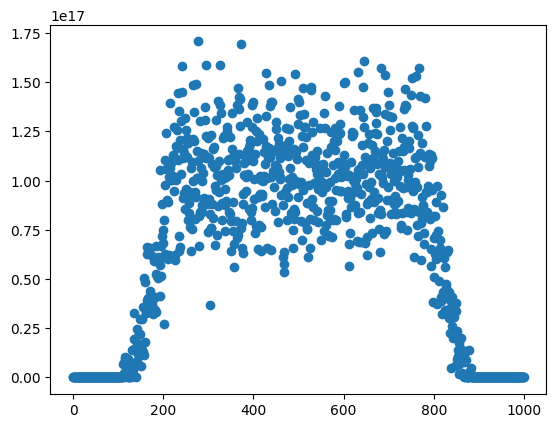

In [73]:
plt.scatter(np.arange(N_x+1), e_conc_history[-1], color="k", s=5 )

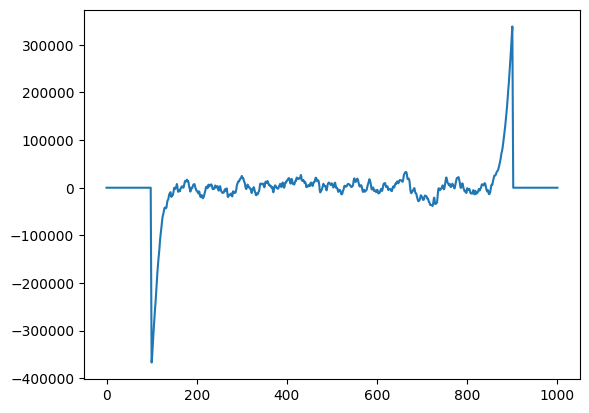

In [48]:
plt.plot(E_history[100])

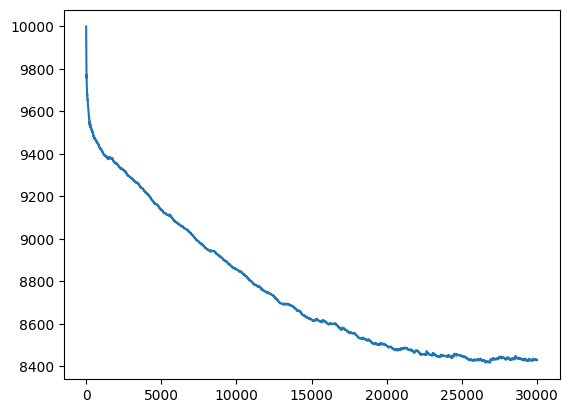

In [70]:
plt.plot(electrons_over_time)

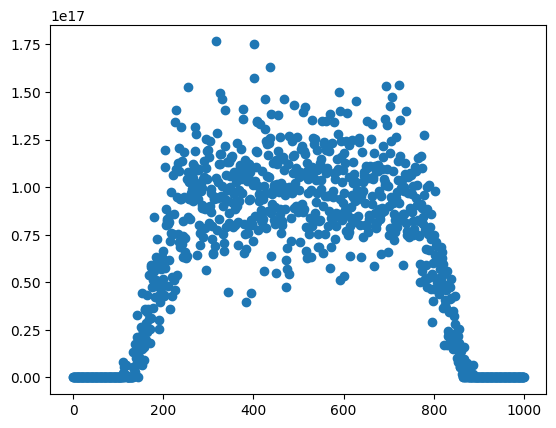

In [59]:
plt.scatter(np.arange(1001), conc_history[25000])

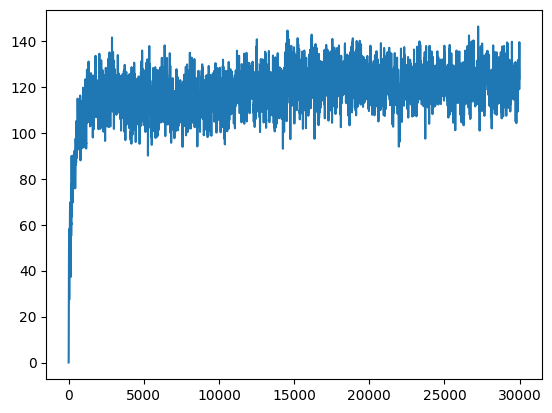

In [71]:
plt.plot(phi_center)

MovieWriter imagemagick unavailable; using Pillow instead.


list index out of range
done!


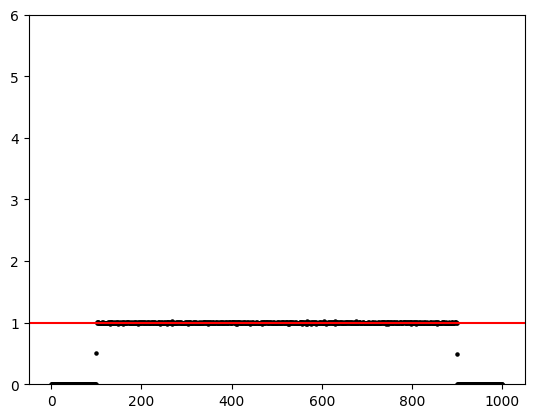

In [157]:
try:
    fig, ax = plt.subplots()

    #  Создаем функцию, генерирующую картинки
    #  для последующей "склейки":
    def animate(i):
        ax.clear()
        ax.set_ylim((0, 6))
        line = ax.scatter(np.arange(N_x+1), conc_history[i*50]/1e17, color="k", s=5)
        ax.axhline(constant_conc/2e17, color="r")
        
        return line

    #  Создаем объект анимации:
    sin_animation = animation.FuncAnimation(fig, 
                                        animate, 
                                        frames=range(int(n)),
                                        interval = 5,
                                        repeat = False)

    #  Сохраняем анимацию в виде gif файла:
    sin_animation.save('results/conc_over_time.gif',
                    writer='imagemagick', 
                    fps=30)
except Exception as e:
    print(e)
    print("done!")

In [53]:
central_phi = np.array([x[500] for x in phi_over_time])

In [159]:
plt.plot(central_phi)

NameError: name 'central_phi' is not defined

In [208]:
phi_spectre = np.fft.rfft(central_phi)

c:\Users\setup\Desktop\PlasmaPython\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


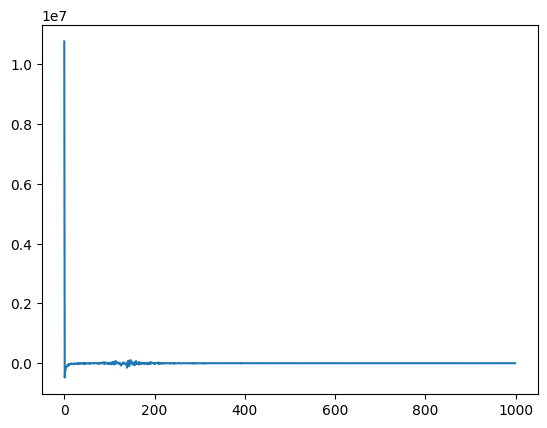

In [209]:
plt.plot(phi_spectre[:1000])

In [210]:
tmax = np.argmin(phi_spectre[10:600])+10

In [211]:
tmax

139

In [212]:
w_exp = tmax*2*np.pi/(n*tau)/1e10
w_exp

1.7467255153959251

In [213]:
w_theory = math.sqrt(n0*q*q/(m_e*epsilon))/1e10
w_theory

1.784401018101099

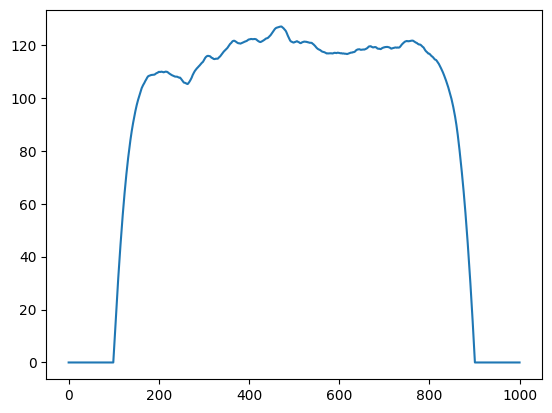

In [118]:
plt.plot(phi_over_time[-1])

In [59]:
electrons.n_macro

8447

In [60]:
ions.n_macro

8858

MovieWriter imagemagick unavailable; using Pillow instead.


list index out of range
done!


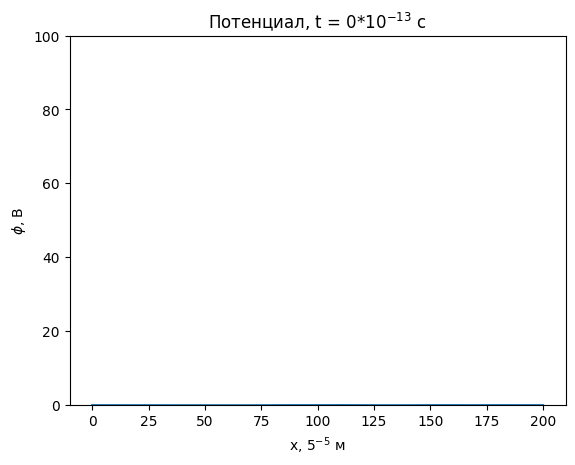

In [169]:
try:
    fig, ax = plt.subplots()

    #  Создаем функцию, генерирующую картинки
    #  для последующей "склейки":
    def animate(i):
        ax.clear()
        line = ax.plot(phi_over_time[i*200])
        ax.set_title("Потенциал, t = " + str(2*i*200)+ r"$*10^{-13}$ c")
        #ax.axvline(x=left_wall.right, color='k', linestyle='--', linewidth=1)
        #ax.set_xlim(left_wall.right, right_wall.left)
        ax.set_ylim(0, 100)
        ax.set_ylabel(r"$\phi$, В")
        ax.set_xlabel(r"x, $5^{-5}$ м")
        return line

    #  Создаем объект анимации:
    sin_animation = animation.FuncAnimation(fig, 
                                        animate, 
                                        frames=range(n),
                                        interval = 5,
                                        repeat = False)

    #  Сохраняем анимацию в виде gif файла:
    sin_animation.save('results/phi_over_time.gif',
                    writer='imagemagick', 
                    fps=30)
except Exception as e:
    print(e)
    print("done!")

MovieWriter imagemagick unavailable; using Pillow instead.


list index out of range
done!


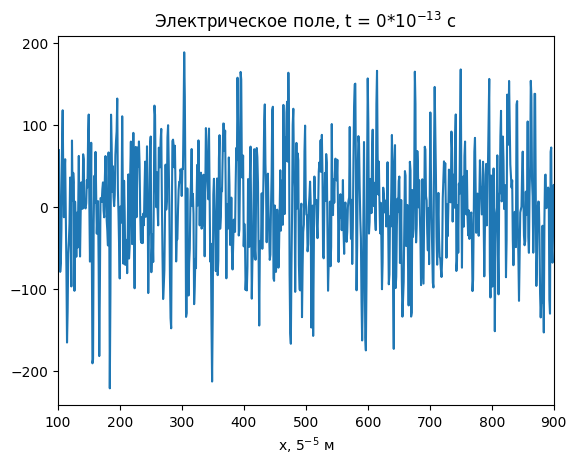

In [49]:
try:
    fig, ax = plt.subplots()

    #  Создаем функцию, генерирующую картинки
    #  для последующей "склейки":
    def animate(i):
        ax.clear()
        line = ax.plot(E_history[i*50])
        ax.set_title("Электрическое поле, t = " + str(2*i*50)+ r"$*10^{-13}$ c")
        ax.set_xlim(left_wall.right, right_wall.left)
        ax.set_xlabel(r"x, $5^{-5}$ м")
        return line

    #  Создаем объект анимации:
    sin_animation = animation.FuncAnimation(fig, 
                                        animate, 
                                        frames=range(n),
                                        interval = 5,
                                        repeat = False)

    #  Сохраняем анимацию в виде gif файла:
    sin_animation.save('results/E_over_time.gif',
                    writer='imagemagick', 
                    fps=30)
except Exception as e:
    print(e)
    print("done!")

MovieWriter imagemagick unavailable; using Pillow instead.


list index out of range
done!


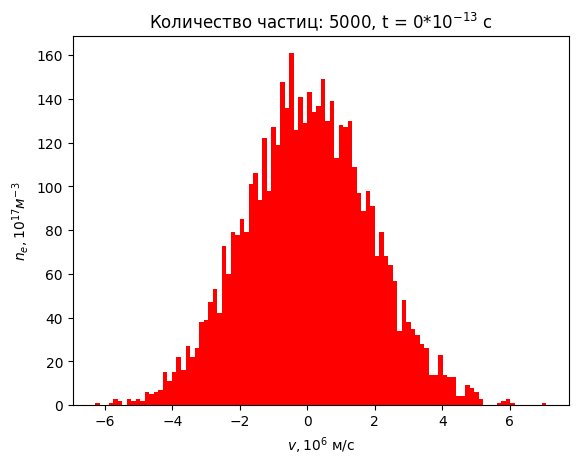

In [166]:
try:
    fig, ax = plt.subplots()

    #  Создаем функцию, генерирующую картинки
    #  для последующей "склейки":
    def animate(i):
        ax.clear()
        # Calculate the bin width based on the data
        data_min = min(np.min(electron_distrs[i*50]/1e6), np.min(ion_distrs[0]/1000))
        data_max = max(np.max(electron_distrs[i*50]/1e6), np.max(ion_distrs[0]/1000))
        bin_width = 2*(np.percentile(electron_distrs[i*50]/1e6, 75) - np.percentile(electron_distrs[i*50]/1e6, 25))/len(electron_distrs[i*50])**(1/3)
        bins = np.arange(data_min, data_max + bin_width, bin_width)

        line = ax.hist(electron_distrs[0]/1e6, bins=100, color="b")
        ax.hist(electron_distrs[i*50]/1e6, bins=100, color = "r")
        ax.set_title("Количество частиц: " + str(len(electron_distrs[i*50])) + 
                     ", t = " + str(2*i*50)+ r"$*10^{-13}$ c")
        ax.set_ylabel(r"$n_e, 10^{17} м^{-3}$")
        ax.set_xlabel(r"$v, 10^{6}$ м/c")
        return line

    #  Создаем объект анимации:
    sin_animation = animation.FuncAnimation(fig, 
                                        animate, 
                                        frames=range(n),
                                        interval = 5,
                                        repeat = False)

    #  Сохраняем анимацию в виде gif файла:
    sin_animation.save('results/electron_distrs_over_time.gif',
                    writer='imagemagick', 
                    fps=30)
except Exception as e:
    print(e)
    print("done!")

MovieWriter imagemagick unavailable; using Pillow instead.


list index out of range
done!


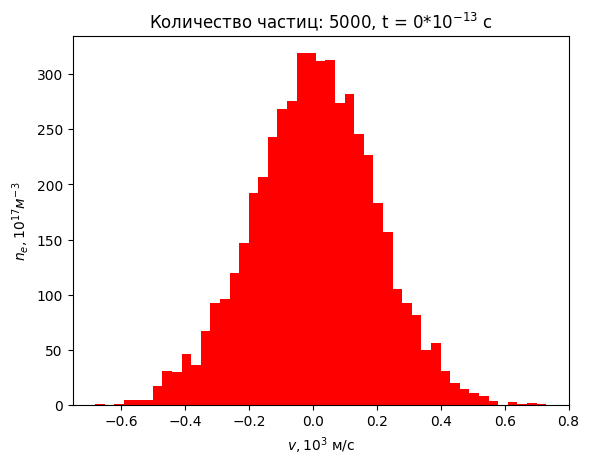

In [167]:
try:
    fig, ax = plt.subplots()

    #  Создаем функцию, генерирующую картинки
    #  для последующей "склейки":
    def animate(i):
        ax.clear()
        # Calculate the bin width based on the data
        data_min = min(np.min(ion_distrs[i*50]/1000), np.min(ion_distrs[0]/1000))
        data_max = max(np.max(ion_distrs[i*50]/1000), np.max(ion_distrs[0]/1000))
        bin_width = 2*(np.percentile(ion_distrs[i*50]/1000, 75) - np.percentile(ion_distrs[i*50]/1000, 25))/len(ion_distrs[i*50])**(1/3)
        bins = np.arange(data_min, data_max + bin_width, bin_width)
        
        line = ax.hist(ion_distrs[0]/1000, bins=bins, color="b")
        ax.hist(ion_distrs[i*50]/1000, bins=bins, color="r")
        
        ax.set_title("Количество частиц: " + str(len(ion_distrs[i*50])) + 
                     ", t = " + str(2*i*50)+ r"$*10^{-13}$ c")
        ax.set_ylabel(r"$n_e, 10^{17} м^{-3}$")
        ax.set_xlabel(r"$v, 10^{3}$ м/c")
        return line

    #  Создаем объект анимации:
    sin_animation = animation.FuncAnimation(fig, 
                                        animate, 
                                        frames=range(n),
                                        interval = 5,
                                        repeat = False)

    #  Сохраняем анимацию в виде gif файла:
    sin_animation.save('results/ion_distrs_over_time.gif',
                    writer='imagemagick', 
                    fps=30)
except Exception as e:
    print(e)
    print("done!")

In [112]:
import os
import imageio

gif_dir = 'results/'
paired_gif_dir = 'paired_gifs/'

SEE_gif_files = [filename for filename in os.listdir(gif_dir) if filename.startswith('SEE') and filename.endswith('.gif')]
reg_gif_files = [filename for filename in os.listdir(gif_dir) if not filename.startswith('SEE') and filename.endswith('.gif')]

for SEE_gif_file in SEE_gif_files:
    SEE_gif_path = os.path.join(gif_dir, SEE_gif_file)
    reg_gif_file = SEE_gif_file.replace('SEE', '').lstrip('_')
    reg_gif_path = os.path.join(gif_dir, reg_gif_file)
    if os.path.exists(reg_gif_path):
        SEE_gif = imageio.mimread(SEE_gif_path, memtest=False)
        reg_gif = imageio.mimread(reg_gif_path, memtest=False)
        paired_gifs = [np.concatenate((reg_frame, SEE_frame), axis=1) for reg_frame, SEE_frame in zip(reg_gif, SEE_gif)]
        paired_gif_path = os.path.join(paired_gif_dir, SEE_gif_file.replace('SEE', 'paired'))
        imageio.mimwrite(paired_gif_path, paired_gifs, format='gif', fps=30)


In [37]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt

# Set directory paths
reg_gif_dir = 'path/to/regular/gifs'
SEE_gif_dir = 'path/to/SEE/gifs'
paired_gif_dir = 'path/to/paired/gifs'

# Loop through SEE gifs
for SEE_gif_file in os.listdir(SEE_gif_dir):
    if SEE_gif_file.startswith('SEE'):
        # Load regular gif
        reg_gif_file = SEE_gif_file.replace('SEE', '')
        reg_gif_path = os.path.join(reg_gif_dir, reg_gif_file)
        reg_gif = imageio.mimread(reg_gif_path)

        # Load SEE gif
        SEE_gif_path = os.path.join(SEE_gif_dir, SEE_gif_file)
        SEE_gif = imageio.mimread(SEE_gif_path)

        # Combine frames
        paired_gifs = [np.concatenate((reg_frame, SEE_frame), axis=1) for reg_frame, SEE_frame in zip(reg_gif, SEE_gif)]

        # Add title to each frame
        for i, frame in enumerate(paired_gifs):
            fig, ax = plt.subplots()
            ax.imshow(frame, cmap='gray')
            if i == 0:
                ax.set_title('Regular GIF                          SEE GIF')
            plt.axis('off')

            # Save frame
            paired_gif_path = os.path.join(paired_gif_dir, SEE_gif_file.replace('SEE', 'paired'))
            imageio.imwrite(paired_gif_path, frame)

        # Combine frames into GIF
        paired_gif_path = os.path.join(paired_gif_dir, SEE_gif_file.replace('SEE', 'paired'))
        with imageio.get_writer(paired_gif_path, mode='I', fps=30) as writer:
            for frame in paired_gifs:
                writer.append_data(frame)


FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: 'path/to/SEE/gifs'

In [39]:
ions_over_time = np.array([len(x) for x in ion_distrs])

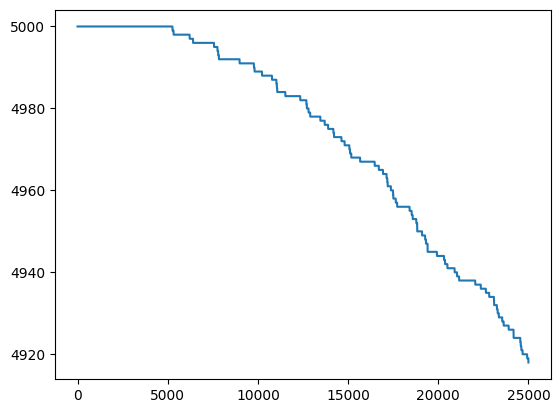

In [40]:
plt.plot(ions_over_time)

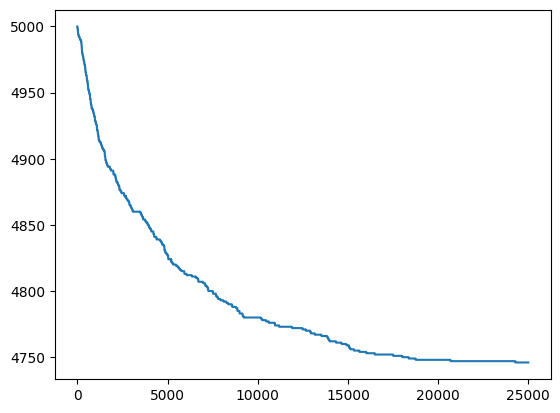

In [41]:
electrons_over_time = np.array([len(x) for x in electron_distrs])
plt.plot(electrons_over_time)


(array([2.50911614e-07, 4.18186024e-07, 1.67274409e-07, 3.34548819e-07,
        3.34548819e-07, 4.18186024e-07, 5.01823228e-07, 2.50911614e-07,
        2.50911614e-07, 4.18186024e-07, 6.69097638e-07, 5.85460433e-07,
        3.34548819e-07, 8.36372047e-07, 5.01823228e-07, 4.18186024e-07,
        9.20009252e-07, 8.36372047e-07, 9.20009252e-07, 1.42183248e-06,
        1.00364646e-06, 2.09093012e-06, 1.14582970e-05, 6.73279498e-05,
        1.47786941e-04, 1.19099380e-04, 3.40403423e-05, 5.01823228e-06,
        1.58910689e-06, 7.52734843e-07, 1.33819528e-06, 1.17092087e-06,
        6.69097638e-07, 5.01823228e-07, 7.52734843e-07, 4.18186024e-07,
        5.85460433e-07, 5.01823228e-07, 4.18186024e-07, 5.01823228e-07,
        4.18186024e-07, 4.18186024e-07, 4.18186024e-07, 5.01823228e-07,
        5.01823228e-07, 1.67274409e-07, 3.34548819e-07, 4.18186024e-07,
        8.36372047e-08, 2.50911614e-07]),
 array([-60222.11855083, -57790.96737177, -55359.81619272, -52928.66501366,
        -50497.513

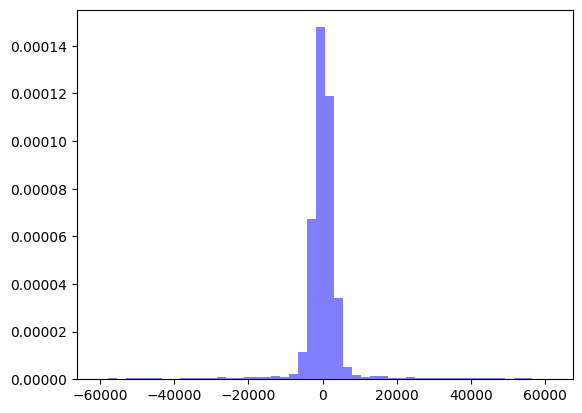

In [44]:
plt.hist(ion_distrs[-1], bins=50, density=True, facecolor='blue', alpha=0.5)

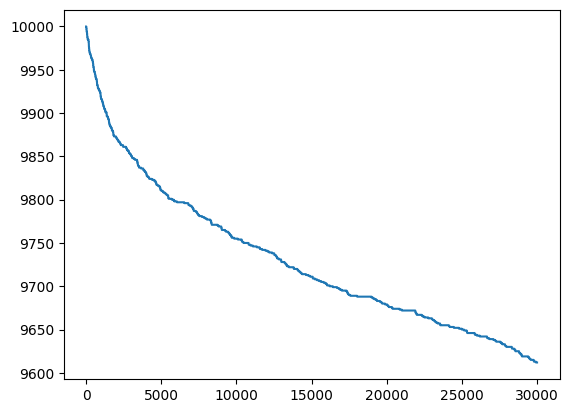

In [39]:
plt.plot(electrons_over_time+ions_over_time)
